# Simulated annealing

- https://qiita.com/meltyyyyy/items/096efb08fb4ec532c330
- https://qiita.com/ttabata/items/45a616d8dce6c07538e1

In [1]:
import os
from os import getpid, getppid
import random
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from algorithms.genetic_algorithm import initial_population, Chromosome
from algorithms.simulated_annealing import simulated_annealing
from la40.loader import read_benchmark_task_data
from la40.score_calculator import ScoreCalculator
from utils.paths import JSSP_DATA_PATH

seed = 0
random.seed(seed)
np.random.seed(seed)


In [2]:
def cool(T, cooling_rate: float = 0.9): return cooling_rate * T


def simulate(cooling_rate=0.9):
    T = 1.
    t_hist = []
    for _ in range(0, 100):
        T = cool(T, cooling_rate=cooling_rate)
        t_hist.append(T)
    return t_hist


t_hist_0 = simulate(0.9)
t_hist_1 = simulate(0.95)
t_hist_2 = simulate(0.99)


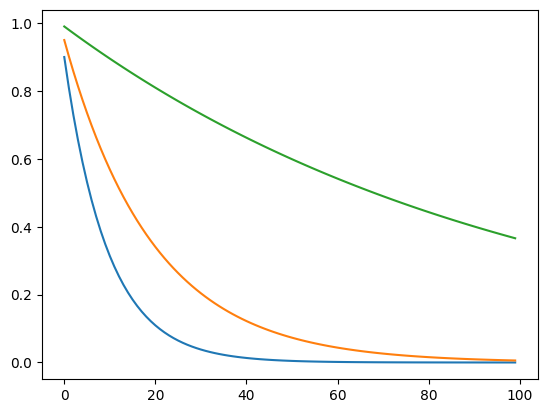

In [3]:
plt.plot(t_hist_0, label="0.9")
plt.plot(t_hist_1, label="0.95")
plt.plot(t_hist_2, label="0.99")

# Practice

## load benchmark data

In [4]:
# la40
processing_time_per_job, machine_sequence_per_job = read_benchmark_task_data(
    os.path.join(JSSP_DATA_PATH, "ta80.txt")
)

processing_time_per_job = pd.DataFrame(processing_time_per_job).astype(int)
machine_sequence_per_job = pd.DataFrame(machine_sequence_per_job).astype(int)

num_job = processing_time_per_job.shape[0]  # number of jobs
num_machine = processing_time_per_job.shape[1]  # number of machines
num_gene = num_machine * num_job  # number of genes in a chromosome

# processing_times
pt = processing_time_per_job.values.tolist()
#　machine_sequences for tasks
ms = machine_sequence_per_job.values.tolist()

num_job, num_machine


(100, 20)

## multiprocess function

In [5]:
def multi_process(func, args_list: list):
    p = Pool(cpu_count() - 1) # プロセス数を指定する

    try:
        result = p.map(func, args_list)  # リストで引数を指定する
    except Exception as e:
        print("main: ", e)
    finally:
        # プロセスの終了
        p.close()

    return result


def simulated_annealing_wrapper(args):
    print("[p:{}---c:{}] {}\n".format(getppid(), getpid(), [args["steps"]]))
    return simulated_annealing(**args)


## Optimization

In [6]:
calculator = ScoreCalculator(pt, ms)
trial_num = 10
chromosomes: Chromosome = initial_population(num_gene, num_job, population_size=trial_num)
args: list[dict] = [
    {"calculator": calculator, "curr_solution": chromosome, "steps": 9999999}
    for chromosome in chromosomes
]

result = multi_process(simulated_annealing_wrapper, args)


[p:12165---c:12224] [9999999]
[p:12165---c:12225] [9999999]


[p:12165---c:12226] [9999999]



Simulated Annealing:   0% 0/9999999 [00:00<?, ?it/s]

[p:12165---c:12227] [9999999]

[p:12165---c:12228] [9999999]


Simulated Annealing:   0% 0/9999999 [00:00<?, ?it/s]


[p:12165---c:12229] [9999999]


Simulated Annealing:   0% 0/9999999 [00:00<?, ?it/s]


[p:12165---c:12230] [9999999]



Simulated Annealing:   1% 142783/9999999 [09:59<11:37:42, 235.47it/s]
Simulated Annealing:   1% 142452/9999999 [09:59<11:31:59, 237.42it/s]
Simulated Annealing:   1% 142634/9999999 [09:59<11:31:04, 237.73it/s]

Simulated Annealing:   1% 142790/9999999 [09:59<11:30:19, 237.99it/s]

[p:12165---c:12224] [9999999]



Simulated Annealing:   1% 142503/9999999 [09:59<11:41:50, 234.09it/s]

[p:12165---c:12225] [9999999]
[p:12165---c:12226] [9999999]





Simulated Annealing:   1% 142792/9999999 [09:59<11:30:18, 237.99it/s]
Simulated Annealing:   1% 142510/9999999 [09:59<11:31:41, 237.52it/s]
Simulated Annealing:   2% 198548/9999999 [09:59<8:13:39, 330.92it/s] 
Simulated Annealing:   2% 198699/9999999 [09:59<8:13:16, 331.17it/s]



## Aggregation

In [9]:
best_scores: list[int] = []
computation_times: list[float] = []
hists = []
for hist_scores, best_solution, computation_time in result:
    best_scores.append(-max(hist_scores))
    computation_times.append(computation_time)
    hists.append(hist_scores)

np.mean(best_scores), np.std(best_scores), np.mean(computation_times), np.std(computation_times)


(5580.2, 45.92994665792679, 600.0080811977386, 0.0023446590642301284)

In [12]:
# [
#     hist[:4]
#     for hist in hists
# ]

## Serial exection

In [5]:
calculator = ScoreCalculator(pt, ms)

best_scores: list[int] = []
computation_times: list[float] = []
for i in tqdm(range(0, 10)):
    chromosomes: Chromosome = initial_population(num_gene, num_job, population_size=1)[0]
    score_hist, best_chromosome, computation_time = simulated_annealing(calculator, chromosomes)
    best_scores.append(-max(score_hist))
    computation_times.append(computation_time)

best_scores, computation_times

  0%|          | 0/10 [00:00<?, ?it/s]


Simulated Annealing:   0% 0/100000 [00:00<?, ?it/s]
Simulated Annealing:   0% 184/100000 [00:00<00:54, 1815.22it/s]
Simulated Annealing:   0% 392/100000 [00:00<00:50, 1969.73it/s]
Simulated Annealing:   1% 590/100000 [00:00<00:50, 1961.02it/s]
Simulated Annealing:   1% 799/100000 [00:00<00:49, 2010.77it/s]
Simulated Annealing:   1% 1001/100000 [00:00<00:53, 1842.49it/s]
Simulated Annealing:   1% 1188/100000 [00:00<01:07, 1468.63it/s]
Simulated Annealing:   1% 1347/100000 [00:00<01:24, 1168.84it/s]
Simulated Annealing:   1% 1479/100000 [00:01<01:30, 1086.15it/s]
Simulated Annealing:   2% 1598/100000 [00:01<01:37, 1005.75it/s]
Simulated Annealing:   2% 1705/100000 [00:01<01:42, 959.20it/s] 
Simulated Annealing:   2% 1805/100000 [00:01<01:47, 913.29it/s]
Simulated Annealing:   2% 1899/100000 [00:01<01:53, 866.19it/s]
Simulated Annealing:   2% 1997/100000 [00:01<01:49, 893.19it/s]
Simulated Annealing:   2% 2088/100000 [00:01<01:55, 845.83it/s]
Simulated Annealing:   2% 2175/100000 [00:01<

KeyboardInterrupt: 

In [9]:
np.mean(best_scores), np.std(best_scores), np.mean(computation_times), np.std(computation_times)


(1272.0, 11.806777714516354, 7.470432209968567, 0.07126001100995058)